In [1]:
import sys
import csv
sys.path.append('..')
from BDDData import *
import numpy as np
import torch
import torch.utils.data as data

import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import circulant
from product_graph import *
from utils import *

In [2]:
#Load dataframes
bdd_data = BDD_dataset("raw_data/BDDdata/")
#Add column with the timestep
bdd_data.add_timestep_id()
#Add flags for chaotic values
bdd_data.tag_chaotic(replace=True)
#Compute the mod for the nazelle and wind angles
bdd_data.angle_mod()

# ! Don't interpolate this data
# ! Missing values remain NaN
# #Interpolate the missing values
# bdd_data.interpolate_power()

#Values smaller than 0 are set to 0
bdd_data.cap_power_to_zero()
#Normalize Patv feature to [0,1]
bdd_data.normalize_power(min=0, max=1, method= "MinMaxScaler")
#Convert df to matrix form, where only Patv is included. Then split into train, validation and test
#The matrix contains the subset of the time series for ALL nodes, so an (TxN matrix)
train, val, test = bdd_data.split_df()

print(train.shape)

(134, 24624)


In [3]:
train = train[:,:1000]
val = val[:, :1000]
test = test[:, :1000]

In [4]:
class CustomBDD_Dataset(data.Dataset):
    def __init__(self, dataset, observation_window=12, forecast_window=12, starting_turbine = 0,  ending_turbine=133):
        self.observation_window = observation_window
        self.forecast_window = forecast_window
        length = eval(f'len({dataset}[0])')#Retrieves length of dataset
        bdd_data.get_observation_forecasting_window(time_series_len=length, observation_steps=self.observation_window, forecast_steps=self.forecast_window)#Generates obs window
        self.window_of_interest =  bdd_data.sliding_indices[str(self.observation_window)+","+str(self.forecast_window)]#Retrieves windows
        self.starting_turbine = starting_turbine
        self.ending_turbine = ending_turbine  
        self.dataset = dataset

    def __len__(self):
        return len(self.window_of_interest)

    def __getitem__(self, idx):
        window = self.window_of_interest[idx]
        if self.dataset == "train":
            features = train[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = train[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "val":
            features = val[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = val[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "test":
            features = test[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = test[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        else:
            raise NotImplementedError
        return torch.from_numpy(features).float(), torch.from_numpy(labels).float()
    
obs_window = 12
forecast_window = 12
batch_size = 1

train_dataset = CustomBDD_Dataset("train",observation_window=obs_window,forecast_window=forecast_window)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataset = CustomBDD_Dataset("val",observation_window=obs_window,forecast_window=forecast_window)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size = batch_size)

In [5]:
x,y = next(iter(train_loader))
print(f"{x.shape=}\n{y.shape=}")

x.shape=torch.Size([1, 1608, 1])
y.shape=torch.Size([1, 1608, 1])


In [6]:
G = nx.read_gml('data/spatial_graph_2000.gml')
adj_mat = nx.adjacency_matrix(G)
adj_mat = nx.to_numpy_array(G)


In [7]:
def build_time_graph(window: int, directed: bool, cyclic: bool):
    """
    Circulant matrix as in https://arxiv.org/pdf/1712.00468.pdf (eq. 7)
    """
    if window <= 1:
        raise Exception("Ehm..")
    adjacency = circulant([0, 1] + [0 for _ in range(window-2)])
    if not cyclic:
        adjacency[0, window-1] = 0
    if not directed:
        adjacency += adjacency.transpose()

    return adjacency

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


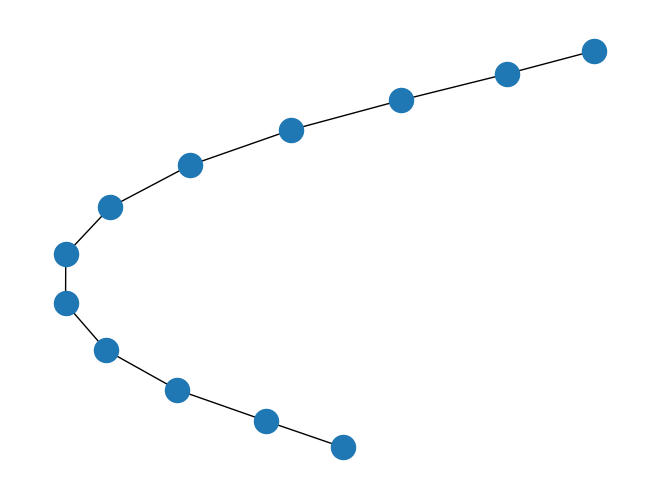

In [8]:
timegraph = build_time_graph(12,True,False)
print(timegraph)
tg = nx.from_numpy_array(timegraph)
nx.draw(tg)

In [9]:
S = torch.tensor(adj_mat)
S_t = torch.tensor(timegraph)

In [10]:
pg = build_parametric_product_graph(S_t, S, 0, 1, 1, 1)

In [11]:
norm_pg = normalize_adjacency(torch.tensor(pg)).float()

/var/folders/yn/jbnxb2792bx_bmgd675jx1fh0000gq/T/ipykernel_54041/1930423800.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_pg = normalize_adjacency(torch.tensor(pg)).float()


In [12]:
print(norm_pg.shape)

torch.Size([1608, 1608])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gmm_code.gmm_gcnn import GMMGCNN
from gmm_code.gmm_gcn import GMMGCN

# TODO: Should we always take the first time step?
# all_features = train[0, :].reshape(-1, 1)
all_features = train.reshape(-1, 1)
# all_A = S
all_A = norm_pg
print(all_features.shape)
print(all_A.shape)

(134000, 1)
torch.Size([1608, 1608])


In [14]:
import time

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, prediction, target):
        # Create a mask that is 1 for non-NaN entries and 0 for NaN entries
        mask = ~torch.isnan(target)
        # Apply the mask to only keep non-NaN elements
        out = prediction[mask]
        tar = target[mask]
        # Calculate MSE Loss on non-NaN elements
        return nn.functional.mse_loss(out, tar)

def train_epoch_gcnn(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        # Remove dimension of size 1.
        # ! Does not work yet with batches
        # x = x[0, :, :]
        # y = y[0, :, :]

        out = model(all_A, x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def evaluate_epoch_gcnn(model, loader, criterion):
    model.eval()
    total_loss = 0

    for x, y in loader:
        # Remove dimension of size 1.
        # ! Does not work yet with batches
        # x = x[0, :, :]
        # y = y[0, :, :]
        out = model(all_A, x)
        loss = criterion(out, y)
        total_loss += loss.item()
    return total_loss / len(loader)


def train_gcnn(model, num_epochs, criterion, train_loader, test_loader):
    # TODO: Check loss function!
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        print(epoch)
        # Model training
        train_loss = train_epoch_gcnn(model, train_loader, optimizer, criterion)

        # Model validation
        val_loss = evaluate_epoch_gcnn(model, test_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(
                "epoch:",
                epoch,
                "\t training loss:",
                np.round(train_loss, 4),
                "\t validation loss:",
                np.round(val_loss, 4),
            )

    elapsed_time = time.time() - start_time
    print(f"Model training took {elapsed_time:.3f} seconds")

    return train_losses, val_losses

In [15]:
# n_components = 5
# order = 1
# num_epochs = 1
# model = GMMGCNN(obs_size=1, pred_size=1, hid_sizes=[8], num_components=n_components, all_features=all_features, all_A=all_A, order=order)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# # print(pytorch_total_params)
# train_losses, val_losses = train_gcnn(model, num_epochs, MaskedMSELoss(), train_loader, val_loader)

In [16]:
n_components = 1
order = 1
num_epochs = 1
model = GMMGCN(obs_size=1, pred_size=1, hid_sizes=[128, 128], num_components=n_components, all_features=all_features, all_A=all_A)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(pytorch_total_params)
train_losses, val_losses = train_gcnn(model, num_epochs, MaskedMSELoss(), train_loader, val_loader)

1
epoch: 1 	 training loss: 0.1069 	 validation loss: 0.0568
Model training took 68.233 seconds
